In [18]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_unit import WMSE
from pitchfuncs_unit import InversePCA
from pitchfuncs_unit import emulator
from pitchfuncs_unit import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
from scipy import stats
import astropy.constants
import pickle
from matplotlib.pyplot import cm
import json
import matplotlib.pyplot as plt

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())


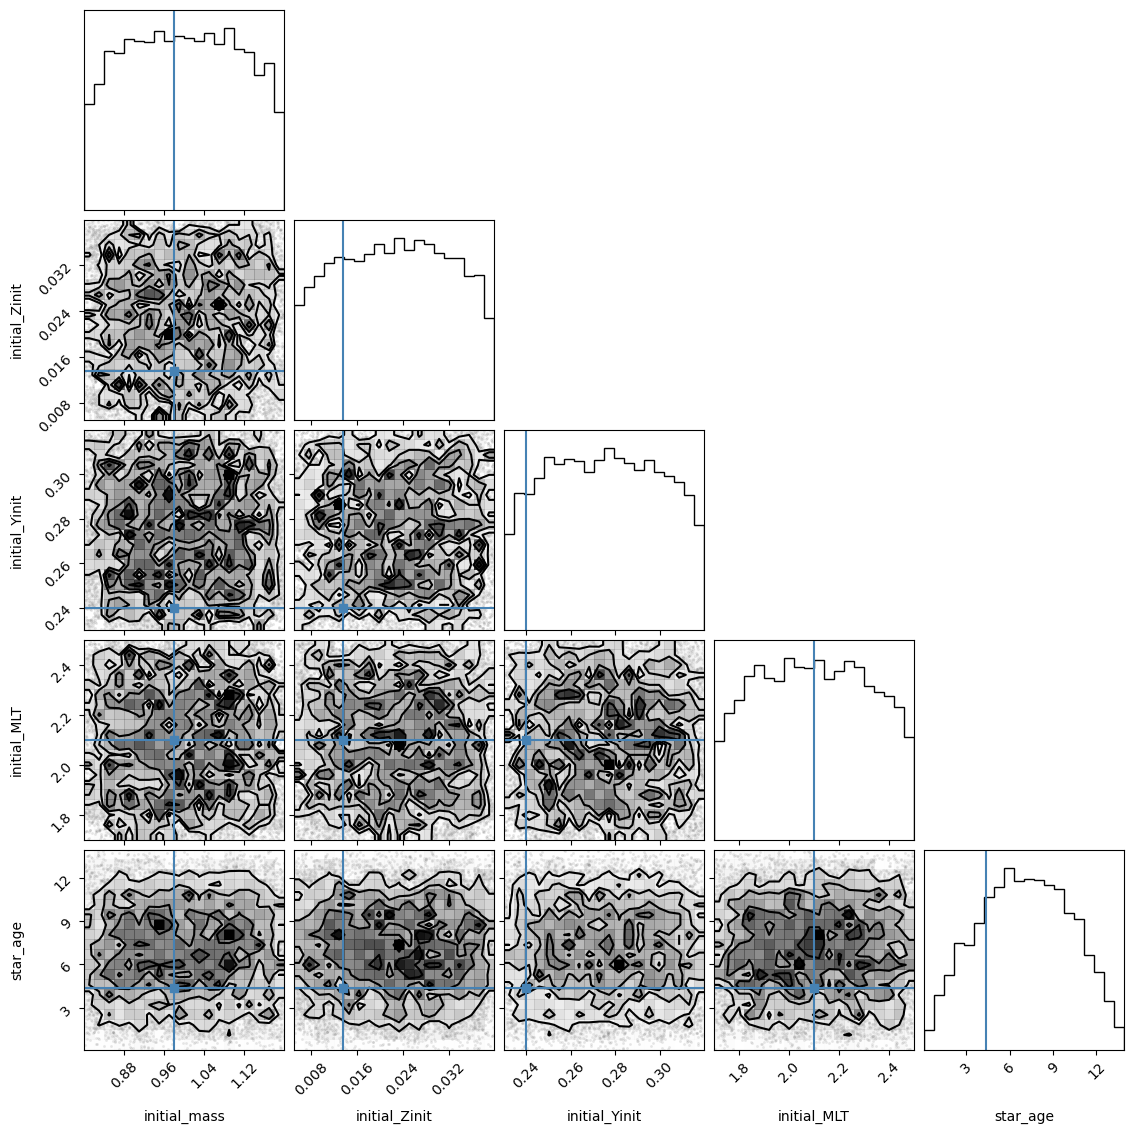

In [19]:
def grid_uniform_prior(pitchfork_ranges, header):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.uniform(loc=grid_min, scale=max(list(pitchfork_ranges["log_"+header].values()))-grid_min)

def grid_beta_prior(pitchfork_ranges, header,a=1,b=1):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.beta(loc=grid_min, scale=grid_max-grid_min, a=a, b=b)

def custom_uniform_prior(prior_min, prior_max):
    return scipy.stats.uniform(loc=prior_min, scale=prior_max-prior_min)

def custom_beta_prior(prior_min, prior_max, a=1, b=1):
    return scipy.stats.beta(loc=prior_min, scale=prior_max-prior_min, a=a, b=b)

mass_prior = custom_beta_prior(0.8, 1.2, a=1.2, b=1.2)

Zinit_prior = custom_beta_prior(0.005, 0.04, a=1.2, b=1.2)

Yinit_prior = custom_beta_prior(0.23, 0.32, a=1.2, b=1.2)

MLT_prior = custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = custom_beta_prior(0, 14, a=2, b=2)

hare = pd.read_json("pickle jar/solar_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});

In [20]:
n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.5 #\muHz

# obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc+0.01*np.abs(((n_max-n_min)/2+n_min)-i) for i in range(n_min,n_max+1)])
obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(n_min,n_max+1)])


pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

emulator_errors = pd.read_json('pickle jar/emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_,log_sigma_det = np.linalg.slogdet(sigma)

m = pitchfork.predict([hare_inps.values[0]], n_min=n_min, n_max=n_max)[0]

residual_matrix = np.matrix(m-hare_true.values[0])

ll = -(len(m)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)-(0.5*residual_matrix*sigma_inv*residual_matrix.T).flat[0]
print(ll)

sigma_cov = stats.Covariance.from_precision(sigma_inv, covariance=sigma)

scipy_logl = scipy.stats.multivariate_normal.logpdf(m, mean=hare_true.values[0], cov=sigma_cov)
print(scipy_logl)

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]
-23.102444780721548
-23.10244478072154


In [24]:
emulator_cov = np.cov(emulator_errors.to_numpy().T)
print(np.sqrt(np.diag(emulator_cov)))

[5.79607541e+00 1.30915066e-02 1.01035627e-03 3.09916506e-01
 3.57662623e-01 3.70137938e-01 3.27692556e-01 3.60724916e-01
 3.35455686e-01 3.51764372e-01 3.50370467e-01 3.76498733e-01
 3.71991274e-01 3.90481587e-01 3.96657992e-01 4.16605335e-01
 4.32142377e-01 4.35816092e-01 4.66717024e-01 4.93647642e-01
 5.06700328e-01 5.20395427e-01 5.51738686e-01 5.89513047e-01
 5.82269935e-01 6.40206479e-01 6.50775186e-01 6.70592490e-01
 7.39059851e-01 7.24057077e-01 8.18778467e-01 8.37319912e-01
 8.53825069e-01 9.61324059e-01 8.88927418e-01 9.91035820e-01
 9.77585258e-01 1.03338290e+00]


In [25]:
emulator_errors.describe()

,calc_effective_T,luminosity,star_feh,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,...,nu_0_31,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40
count,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,...,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000,122434.000000
mean,-0.060991,0.000208,-0.000021,-0.003188,0.000889,0.004535,0.000654,-0.004213,-0.004563,0.000337,...,-0.009338,-0.007481,-0.007392,-0.010883,-0.019490,-0.031947,-0.038334,-0.022856,0.005817,0.036968
std,5.796075,0.013092,0.001010,0.309917,0.357663,0.370138,0.327693,0.360725,0.335456,0.351764,...,0.739060,0.724057,0.818778,0.837320,0.853825,0.961324,0.888927,0.991036,0.977585,1.033383
min,-125.992612,-0.311675,-0.018227,-3.068580,-2.481259,-3.200201,-3.676832,-4.588483,-5.783368,-5.825031,...,-10.971206,-12.545051,-15.220479,-16.157360,-17.736667,-20.215514,-21.638995,-21.240270,-20.143504,-19.063860
25%,-2.210273,-0.001608,-0.000423,-0.184492,-0.224703,-0.221697,-0.192200,-0.227561,-0.201522,-0.206944,...,-0.434254,-0.413436,-0.465686,-0.478127,-0.467910,-0.514956,-0.488477,-0.546772,-0.495166,-0.521102
50%,-0.078285,0.000036,-0.000017,-0.001172,0.004016,0.001416,0.004986,0.000138,0.002511,0.010239,...,0.003125,0.014535,0.009529,0.001421,0.031109,0.029585,0.010115,0.019535,0.040005,0.072186
75%,2.000478,0.001720,0.000385,0.185725,0.220185,0.233296,0.202090,0.216976,0.203317,0.220436,...,0.428750,0.427703,0.472463,0.457613,0.493594,0.539281,0.470984,0.561334,0.558212,0.628370
max,132.481645,0.282838,0.023735,3.605058,2.978532,3.539287,3.945519,4.484457,4.725136,5.323707,...,13.711264,13.791029,13.757679,14.156637,14.608087,14.666108,14.864014,15.283663,15.587516,16.134179


In [15]:
n_min = 15
n_max = 25

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.5 #\muHz

# obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc+0.01*np.abs(((n_max-n_min)/2+n_min)-i) for i in range(n_min,n_max+1)])
obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(n_min,n_max+1)])


pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

emulator_errors = pd.read_json('pickle jar/emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_,log_sigma_det = np.linalg.slogdet(sigma)

m = pitchfork.predict([hare_inps.values[0]], n_min=n_min, n_max=n_max)[0]

residual_matrix = np.matrix(m-hare_true.values[0])

ll = -(len(m)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)-(0.5*residual_matrix*sigma_inv*residual_matrix.T).flat[0]
print(ll)

sigma_cov = stats.Covariance.from_precision(sigma_inv, covariance=sigma)

scipy_logl = scipy.stats.multivariate_normal.logpdf(m, mean=hare_true.values[0], cov=sigma_cov)
print(scipy_logl)

print(log_sigma_det)

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]
-6.317274809543013
-6.317274809543013
-13.994687215188067


In [29]:
n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.5 #\muHz

# obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc+0.01*np.abs(((n_max-n_min)/2+n_min)-i) for i in range(n_min,n_max+1)])
obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[1e6 for i in range(n_min,n_max+1)])
obs_unc[12:23] = frequency_unc


pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

emulator_errors = pd.read_json('pickle jar/emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_,log_sigma_det = np.linalg.slogdet(sigma)

m = pitchfork.predict([hare_inps.values[0]], n_min=n_min, n_max=n_max)[0]

residual_matrix = np.matrix(m - hare_true.values[0])

ll = -(len(m)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)-(0.5*residual_matrix*sigma_inv*residual_matrix.T).flat[0]
print(ll)

sigma_cov = stats.Covariance.from_precision(sigma_inv, covariance=sigma)

scipy_logl = scipy.stats.multivariate_normal.logpdf(m, mean=hare_true.values[0], cov=sigma_cov)
print(scipy_logl)
print(log_sigma_det)

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]
-359.94405299760575
-359.9440529976057
649.149819567103


In [30]:
n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0 #\muHz

# obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc+0.01*np.abs(((n_max-n_min)/2+n_min)-i) for i in range(n_min,n_max+1)])
obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[0 for i in range(n_min,n_max+1)])
obs_unc[12:23] = frequency_unc


pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

emulator_errors = pd.read_json('pickle jar/emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_,log_sigma_det = np.linalg.slogdet(sigma)

m = pitchfork.predict([hare_inps.values[0]], n_min=n_min, n_max=n_max)[0]

residual_matrix = np.matrix(m - hare_true.values[0])

ll = -(len(m)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)-(0.5*residual_matrix*sigma_inv*residual_matrix.T).flat[0]
print(ll)

sigma_cov = stats.Covariance.from_precision(sigma_inv, covariance=sigma)

scipy_logl = scipy.stats.multivariate_normal.logpdf(m, mean=hare_true.values[0], cov=sigma_cov)
print(scipy_logl)
print(log_sigma_det)

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]
-2.7617516056542506
-2.761751605654201
-92.47999673402755


In [31]:
n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0 #\muHz

# obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc+0.01*np.abs(((n_max-n_min)/2+n_min)-i) for i in range(n_min,n_max+1)])
obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[0.5 for i in range(n_min,n_max+1)])
obs_unc[12:23] = frequency_unc


pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

emulator_errors = pd.read_json('pickle jar/emulator_errors.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_,log_sigma_det = np.linalg.slogdet(sigma)

m = pitchfork.predict([hare_inps.values[0]], n_min=n_min, n_max=n_max)[0]

residual_matrix = np.matrix(m - hare_true.values[0])

ll = -(len(m)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)-(0.5*residual_matrix*sigma_inv*residual_matrix.T).flat[0]
print(ll)

sigma_cov = stats.Covariance.from_precision(sigma_inv, covariance=sigma)

scipy_logl = scipy.stats.multivariate_normal.logpdf(m, mean=hare_true.values[0], cov=sigma_cov)
print(scipy_logl)
print(log_sigma_det)

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]
-13.509113737711516
-13.509113737711504
-60.63498280644
